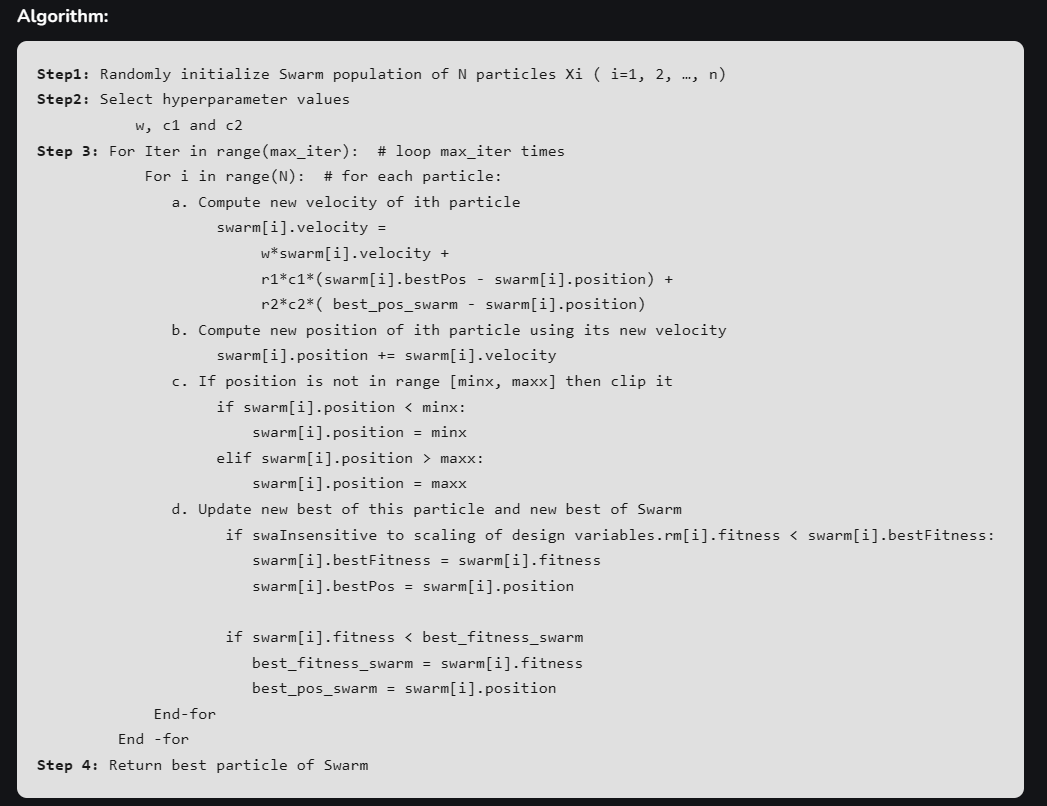

The fitness function:

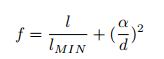

 where *l_min* is the Euclidean distance between actual and desired robot position, α in constant that determine the influence of obstacles and variable *l* and *d* describe qualities of each particle.

Concretely *l* is length of the trajectory computed by equation:

 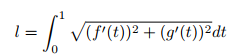

and *d* is minimal distance between trajectory and the closest
obstacle:

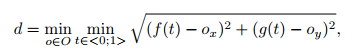

where:

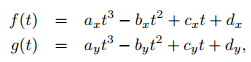

**Cubic Spline**

In [7]:
def cubic_spline_coefficients(p0, p1, p0_prime, p1_prime):
    a = 2 * p0 - 2 * p1 + p0_prime + p1_prime
    b = -3 * p0 + 3 * p1 - 2 * p0_prime - p1_prime
    c = p0_prime
    d = p0
    return a, b, c, d

def cubic_spline_values(a, b, c, d, t):
    return a * t**3 + b * t**2 + c * t + d

def cubic_spline_derivative(a, b, c, d, t):
    return 3 * a * t**2 + 2 * b * t + c

def spline_length(ax, bx, cx, dx, ay, by, cy, dy):
    length_integrand = lambda t: np.sqrt(
        cubic_spline_derivative(ax, bx, cx, dx, t)**2 +
        cubic_spline_derivative(ay, by, cy, dy, t)**2
    )
    length, _ = quad(length_integrand, 0, 1)
    return length

def compute_tangents(points):
    tangents = []
    n = len(points)
    for i in range(n):
        if i == 0:
            tangent = points[i + 1] - points[i]
        elif i == n - 1:
            tangent = points[i] - points[i - 1]
        else:
            tangent = (points[i + 1] - points[i - 1]) / 2
        tangents.append(tangent)
    return np.array(tangents)

def create_spline(points, num_points=100):
    tangents = compute_tangents(points)
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    spline_points = []
    for i in range(n):
        p0, p1 = points[i], points[i + 1]
        p0_prime, p1_prime = tangents[i], tangents[i + 1]
        ax, bx, cx, dx = cubic_spline_coefficients(p0[0], p1[0], p0_prime[0], p1_prime[0])
        ay, by, cy, dy = cubic_spline_coefficients(p0[1], p1[1], p0_prime[1], p1_prime[1])
        for u in t:
            spline_points.append([cubic_spline_values(ax, bx, cx, dx, u),
                                  cubic_spline_values(ay, by, cy, dy, u)])
    return np.array(spline_points)


**PSO Algorithm**



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize_scalar

In [10]:
# the fitness function

def fitness_function(intermediate_points, start, goal, obstacles, l_min, alpha):
    points = np.vstack([start, intermediate_points, goal])
    tangents = compute_tangents(points)
    l = 0
    d = float('inf')
    n = len(points) - 1
    for i in range(n):
        P0 = points[i]
        P1 = points[i + 1]
        P0_prime = tangents[i]
        P1_prime = tangents[i + 1]
        ax, bx, cx, dx = cubic_spline_coefficients(P0[0], P1[0], P0_prime[0], P1_prime[0])
        ay, by, cy, dy = cubic_spline_coefficients(P0[1], P1[1], P0_prime[1], P1_prime[1])
        l += spline_length(ax, bx, cx, dx, ay, by, cy, dy)
        d = min(d, distance_to_obstacles(ax, bx, cx, dx, ay, by, cy, dy, obstacles))
    return l / l_min + (alpha / d)**2

def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def distance_to_obstacles(ax, bx, cx, dx, ay, by, cy, dy, obstacles):
    min_distance = float('INF')
    for obs in obstacles:
        def distance_integrand(t):
            fx = cubic_spline_values(ax, bx, cx, dx, t)
            gx = cubic_spline_values(ay, by, cy, dy, t)
            return np.sqrt((fx - obs[0])**2 + (gx - obs[1])**2)
        result = minimize_scalar(distance_integrand, bounds=(0, 1), method='bounded')
        if result.fun < min_distance:
            min_distance = result.fun
    return min_distance

In [4]:
# generate class Particle

class Particle:
    def __init__(self, position, velocity, bounds):
        self.position = position
        self.velocity = velocity
        self.best_position = position.copy()
        self.best_score = float('inf')
        self.bounds = bounds

    def update_velocity(self, global_best_position, w, c1, c2):
        r1 = np.random.random(self.position.shape)
        r2 = np.random.random(self.position.shape)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        self.position += self.velocity
        for i in range(self.position.shape[0]):
            for j in range(self.position.shape[1]):
                self.position[i, j] = np.clip(self.position[i, j], self.bounds[j, 0], self.bounds[j, 1])
            #end for
        #end for

    def evaluate(self, fitness_function, start, goal, obstacles, l_min, alpha):
        score = fitness_function(self.position, start, goal, obstacles, l_min, alpha)
        if score < self.best_score:
            self.best_score = score
            self.best_position = self.position.copy()
        #end if

# function PSO

def pso(start, goal, obstacles, num_intermediate_points, num_particles, num_iterations, bounds, w=0.5, c1=1.5, c2=1.5):
    particles = [Particle(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_intermediate_points, 2)),
                          np.random.uniform(-1, 1, size=(num_intermediate_points, 2)),
                          bounds) for _ in range(num_particles)]

    global_best_position = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_intermediate_points, 2))
    global_best_score = float('inf')

    positions_over_time = []
    gbest_positions = []

    for iteration in range(num_iterations):
        for particle in particles:
            particle.evaluate(fitness_function, start, goal, obstacles, l_min, alpha)
            if particle.best_score < global_best_score:
                global_best_score = particle.best_score
                global_best_position = particle.best_position.copy()

        positions_over_time.append([p.position.copy() for p in particles])
        gbest_positions.append(global_best_position.copy())

        for particle in particles:
            particle.update_velocity(global_best_position, w, c1, c2)
            particle.update_position()

    return global_best_position, positions_over_time, gbest_positions

In [35]:
# start point, goal and obstacles
points = np.array([
    [5, 10],  # Start point
    [90, 90]   # Goal point
])

obstacles = np.array([
    [40, 40],
    [60, 60],
    [80, 80]
])

# Intermediate points
num_intermediate_points = 5
num_particles= 15
num_iterations= 30

l_min = np.sqrt((points[-1][0] - points[0][0])**2 + (points[-1][1] - points[0][1])**2)
alpha = 1.5

# Define bounds for PSO
bounds = np.array([[0, 100], [0, 100]]) # bounds for x and y coordinates

# Run PSO
best_intermediate_points, positions_over_time, gbest_positions = pso(points[0], points[1], obstacles, num_intermediate_points, num_particles= num_particles, num_iterations= num_iterations, bounds=bounds)
print(f"Best intermediate points found: {best_intermediate_points}")

Best intermediate points found: [[14.54926619 23.5151887 ]
 [20.2915593  31.64762975]
 [29.06363509 44.15599617]
 [34.97404427 50.78459747]
 [71.03789305 85.36855113]]


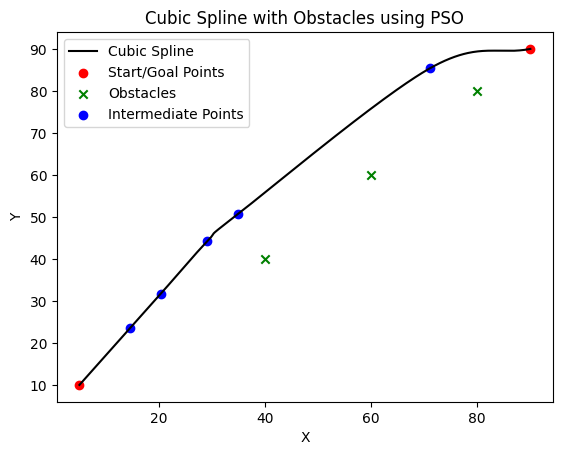

In [36]:
# Combine start, intermediate, and goal points
all_points = np.vstack([points[0], best_intermediate_points, points[1]])

# Create and plot the best spline
spline_points = create_spline(all_points)
plt.plot(spline_points[:, 0], spline_points[:, 1], 'k-', label='Cubic Spline')
plt.scatter(points[:, 0], points[:, 1], c='r', label='Start/Goal Points')
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='g', marker='x', label='Obstacles')
plt.scatter(best_intermediate_points[:, 0], best_intermediate_points[:, 1], c='b', label='Intermediate Points')

plt.title('Cubic Spline with Obstacles using PSO')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()